'To handle label imbalance ,we add class wieghts,it improves learning especially for underrepresented emotions,this especially improves macro F1'

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/185k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/371k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2768 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/232 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5534 [00:00<?, ? examples/s]

<Axes: title={'center': 'Emotion Distribution'}>

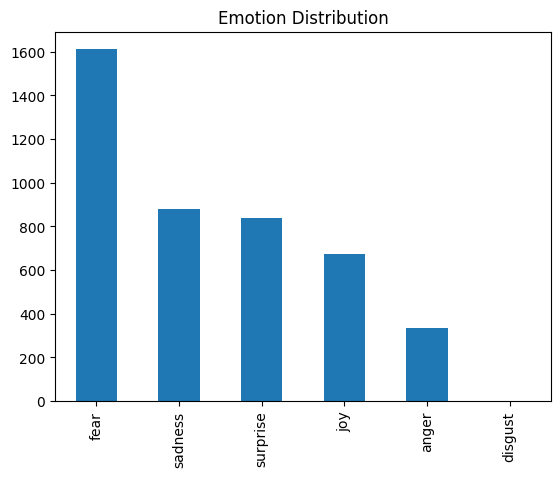

In [2]:
from datasets import load_dataset
import pandas as pd

#ds = load_dataset("BRIGHTER-emotion-categories", "eng", split="train")

dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")

df = pd.DataFrame(dataset['train'])

# Emotion frequency
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
df[emotions].sum().sort_values(ascending=False).plot(kind='bar', title="Emotion Distribution")

In [3]:
from transformers import  AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Initialize the model with the correct number of labels and problem type
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small",
    num_labels=len(label_names),  # Set num_labels to 5 (number of labels)
    problem_type="multi_label_classification",
    hidden_dropout_prob=0.3,  # Increase dropout
    attention_probs_dropout_prob=0.3,
)

# Load tokenizer (no need to reload the model)
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")


# Tokenize and encode labels
def preprocess(example):
    # Tokenize text
    tokenized = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    # Get labels
    tokenized["labels"] = [float(example[label]) for label in label_names]
    return tokenized

encoded_dataset = dataset.map(preprocess, batched=False)

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2768 [00:00<?, ? examples/s]

Map:   0%|          | 0/232 [00:00<?, ? examples/s]

Map:   0%|          | 0/5534 [00:00<?, ? examples/s]

In [4]:
from transformers import TrainingArguments, Trainer , EarlyStoppingCallback
import torch

def compute_metrics(eval_pred):
    from sklearn.metrics import f1_score
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (probs > 0.5).astype(int)
    return {
        "f1_micro": f1_score(labels, predictions, average="micro"),
        "f1_macro": f1_score(labels, predictions, average="macro"),
    }

# Training arguments with regularization
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10,
)

In [6]:
#compte weights for each class

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert training dataset to pandas to compute class frequency
train_df = pd.DataFrame(encoded_dataset["train"])
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']
train_labels = np.array([example["labels"] for example in encoded_dataset["train"]])

# Compute positive class frequencies
class_weights = []
for i in range(len(label_names)):
    y_true = train_labels[:, i]
    # Convert the classes list to a numpy array
    weight = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_true)
    class_weights.append(weight[1])  # Use weight for positive class

# Convert to tensor
import torch
class_weights_tensor = torch.tensor(class_weights).float()
print("Computed class weights:", class_weights_tensor)

Computed class weights: tensor([2.0534, 1.5763, 4.1562, 0.8591, 1.6496])


In [9]:
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # Add num_items_in_batch here
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply sigmoid for multi-label
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor.to(logits.device))
        loss = loss_fn(logits, labels.float())

        return (loss, outputs) if return_outputs else loss

In [10]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["dev"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


<ipython-input-10-d36ce72b7db9>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.808300,0.808341,0.431507,0.140782
2,0.746700,0.634189,0.622093,0.550469
3,0.664900,0.632620,0.615385,0.560685
4,0.631600,0.620201,0.654450,0.610888
5,0.608300,0.604992,0.673522,0.643542


TrainOutput(global_step=865, training_loss=0.6919736035297371, metrics={'train_runtime': 323.3784, 'train_samples_per_second': 42.798, 'train_steps_per_second': 2.675, 'total_flos': 458378047057920.0, 'train_loss': 0.6919736035297371, 'epoch': 5.0})

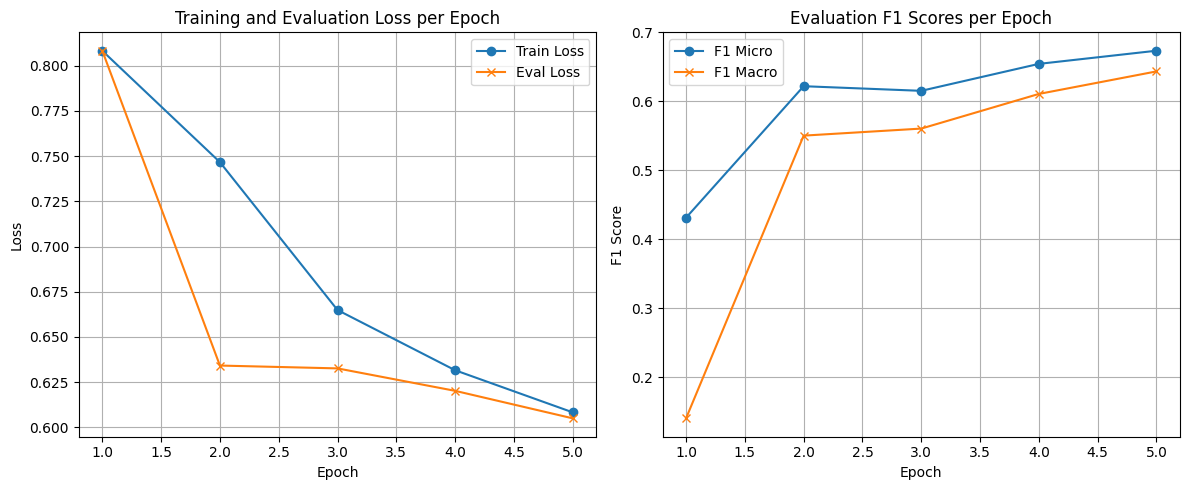

In [11]:
import matplotlib.pyplot as plt

# Extract log history (includes training and eval logs)
log_history = trainer.state.log_history

# Separate values
train_epochs = []
train_loss = []
eval_epochs = []
eval_loss = []
eval_f1_micro = []
eval_f1_macro = []

for log in log_history:
    if "eval_loss" in log:
        eval_epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
        eval_f1_micro.append(log["eval_f1_micro"])
        eval_f1_macro.append(log["eval_f1_macro"])
    if "loss" in log and "epoch" in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])

# Plot
plt.figure(figsize=(12, 5))

# Plot Training and Evaluation Loss
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_loss, marker='o', label="Train Loss")
plt.plot(eval_epochs, eval_loss, marker='x', label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss per Epoch")
plt.grid(True)
plt.legend()

# Plot F1 Scores
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_f1_micro, marker='o', label="F1 Micro")
plt.plot(eval_epochs, eval_f1_macro, marker='x', label="F1 Macro")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Evaluation F1 Scores per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# for 6 epochs
# best condition is this ome, since after epoch 6 overfitting starts

In [12]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Load BRIGHTER dev set
dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
dev_dataset = dataset["dev"] # This is the test dataset

# Define label names
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")

# Define the same preprocessing function used for training
def preprocess(example):
    tokenized = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    tokenized["labels"] = [float(example[label]) for label in label_names]
    return tokenized

# Preprocess the dev set
encoded_test = dev_dataset.map(preprocess, batched=False) # Use dev_dataset here

# Evaluate using Trainer
metrics = trainer.evaluate(encoded_test)
print("Validation Metrics:", metrics)

# Predict raw logits using Trainer
raw_preds = trainer.predict(encoded_test)

# Convert logits to probabilities
probs = torch.sigmoid(torch.tensor(raw_preds.predictions)).numpy()

# Apply threshold (0.5) to get binary labels
binary_preds = (probs > 0.5).astype(int)

#  Prepare submission file
submission_df = pd.DataFrame(binary_preds, columns=label_names)
submission_df.insert(0, "id", dev_dataset["id"]) # Use dev_dataset here as well

#  Save to CSV
submission_df.to_csv("submission_dev.csv", index=False)
print("Submission saved to submission_dev.csv")

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/232 [00:00<?, ? examples/s]

Validation Metrics: {'eval_loss': 0.6049915552139282, 'eval_f1_micro': 0.6735218508997429, 'eval_f1_macro': 0.6435417697849639, 'eval_runtime': 1.1152, 'eval_samples_per_second': 208.037, 'eval_steps_per_second': 13.451, 'epoch': 5.0}
Submission saved to submission_dev.csv


In [13]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Load submission file
submission_df = pd.read_csv("submission_dev.csv")  # Adjust path if needed

# 2. Load gold labels from 'dev' set
dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
gold_df = pd.DataFrame(dataset["dev"])

# 3. Align dataframes by 'id'
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']
submission_df = submission_df.set_index("id").sort_index()
gold_df = gold_df.set_index("id").sort_index()
submission_df = submission_df.loc[gold_df.index]
gold_labels = gold_df[label_names].astype(int)

# 4. Calculate metrics
binary_preds = submission_df[label_names].values
true_labels = gold_labels.values

# Macro
precision_macro = precision_score(true_labels, binary_preds, average="macro", zero_division=0)
recall_macro = recall_score(true_labels, binary_preds, average="macro", zero_division=0)
f1_macro = f1_score(true_labels, binary_preds, average="macro", zero_division=0)

# Micro
precision_micro = precision_score(true_labels, binary_preds, average="micro", zero_division=0)
recall_micro = recall_score(true_labels, binary_preds, average="micro", zero_division=0)
f1_micro = f1_score(true_labels, binary_preds, average="micro", zero_division=0)

# 5. Print report
print("Evaluation Metrics Breakdown")
print(" Macro Average:")
print(f"   Precision: {precision_macro:.4f}")
print(f"   Recall:    {recall_macro:.4f}")
print(f"   F1 Score:  {f1_macro:.4f}")
print("\n Micro Average:")
print(f"   Precision: {precision_micro:.4f}")
print(f"   Recall:    {recall_micro:.4f}")
print(f"   F1 Score:  {f1_micro:.4f}")


Evaluation Metrics Breakdown
 Macro Average:
   Precision: 0.6040
   Recall:    0.7242
   F1 Score:  0.6435

 Micro Average:
   Precision: 0.6150
   Recall:    0.7443
   F1 Score:  0.6735


without class tuning for underrepresented labels,results were this:

---Evaluation Metrics Breakdown

 -Macro Average:

   Precision: 0.5548

   Recall:    0.4372

   F1 Score:  0.4786


 -Micro Average:

   Precision: 0.7048

   Recall:    0.5579

   F1 Score:  0.6228


   --- after adding wieghts, results increases

   Evaluation Metrics Breakdown

 -Macro Average:

   Precision: 0.6040

   Recall:    0.7242

   F1 Score:  0.6435


 -Micro Average:

   Precision: 0.6150

   Recall:    0.7443

   F1 Score:  0.6735
